In [1]:
import cosmopower as cp
import frb_cov as frb
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as units
import numpy as np
from astropy.coordinates import Longitude, Latitude
import matplotlib.pyplot as plt
import pandas as pd
import time

bias_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/bias_sq_model")
power_emu = cp.cosmopower_NN(restore=True, restore_filename="./../cosmopower/pkmm_nonlin_model")




In [ ]:
#file_paths = ['./../data/FRBCat_arXiv2307.03344.csv', './../data/FRBCat_arXiv2302.14788.csv', './../data/catalogue_updated.csv']
file_paths = ['./../data/00.New_FRB_Data.csv']
ra_labels = ['RA (FRB)', 'ra (deg)', 'RA']
dec_labels = ['Dec (FRB)', 'dec (deg)', 'DEC']
redshift_labels = ['z (host)', 'redshift', 'z_gal','Redshift']
DM_obs_labels = ['DM (pc/cm3)',"dm", 'DM_obs', 'DMobs']
DM_MW_labels = ['DM_ISM (pc/cm3)',"dm_milky_way", 'DM_MW', 'DMmw']
frb_name_labels = ['FRB', 'frb', 'Name']

frb_name = []
ra = []
dec = []
zet = []
DM_obs = []
DM_MW = []
frb_id = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    for keys in frb_name_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                frb_name.append(i_aux)
        except:
            continue
    for keys in ra_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                ra.append(i_aux)
        except:
            continue
    for keys in dec_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                dec.append(i_aux)
        except:
            continue
    for keys in DM_obs_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_obs.append(i_aux)
        except:
            continue
    for keys in redshift_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                zet.append(i_aux)
        except:
            continue
    for keys in DM_MW_labels:
        try:
            aux = np.array(df[keys])
            for i_aux in aux:
                DM_MW.append(i_aux)
        except:
            continue

ra = np.array(ra)
dec = np.array(dec)
DM_obs = np.array(DM_obs)
DM_MW = np.array(DM_MW)
zet = np.array(zet)
take_index = np.sort(np.unique(zet, return_index=True)[1])
ra = ra[take_index]
dec = dec[take_index]
DM_obs = DM_obs[take_index]
DM_MW = DM_MW[take_index]
zet = zet[take_index]
ra = coord.Angle(ra, unit=units.degree)
dec = coord.Angle(dec, unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian
n_with_host = len(zet)

#print(DM_obs)


'''
idx = np.where(np.logical_and(DM_obs>1000, DM_obs -DM_MW < 0))
#idx = np.append(idx,[11,12,17,20])
DM_obs = np.delete(DM_obs,idx)
zet = np.delete(zet,idx)
ra = np.delete(ra,idx)
dec = np.delete(dec,idx)
DM_MW = np.delete(DM_MW,idx)
frb_name = np.delete(frb_name,idx)
n_with_host = len(zet)
'''
idx_exclude = np.logical_and(DM_obs>2000, DM_obs -DM_MW < 0)

idx = np.logical_and(DM_obs<2000, DM_obs -DM_MW > 0)
DM_obs = DM_obs[idx]
DM_MW = DM_MW[idx]
zet = zet[idx]
ra = ra[idx]
dec = dec[idx]
frb_name = np.delete(frb_name,idx_exclude)

n_with_host = len(zet)


for i in range(len(DM_obs)):
    print(frb_name[i], " & " , DM_obs[i]," & ", zet[i], " & ",DM_MW[i], " & ",np.round(ra[i],4), " & ", np.round(dec[i],4), " \\\ ")


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
FRB20230708A  &  411.51  &  0.105  &  50.0  &  -2.7889  &  -0.9661  \\ 
FRB20191106C  &  332.2  &  0.10775  &  25.0  &  -2.9094  &  0.7505  \\ 
FRB20220914A  &  631.28  &  0.1139  &  55.2  &  -2.8134  &  1.28  \\ 
FRB20190608  &  339.5  &  0.11778  &  37.2  &  -2.7529  &  -0.1378  \\ 
FRB20190110C  &  221.6  &  0.12244  &  37.1  &  -2.8515  &  0.7233  \\ 
FRB20240310A  &  601.8  &  0.127  &  36.0  &  -3.1182  &  -0.7756  \\ 
FRB20240213A  &  357.4  &  0.1185  &  32.1  &  -2.9482  &  1.2929  \\ 
FRB20230628A  &  345.15  &  0.1265  &  30.83  &  -2.9475  &  1.2616

<>:106: SyntaxWarning: invalid escape sequence '\ '
<>:106: SyntaxWarning: invalid escape sequence '\ '
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_29236/1776083358.py:106: SyntaxWarning: invalid escape sequence '\ '
  print(frb_name[i], " & " , DM_obs[i]," & ", zet[i], " & ",DM_MW[i], " & ",np.round(ra[i],4), " & ", np.round(dec[i],4), " \\\ ")


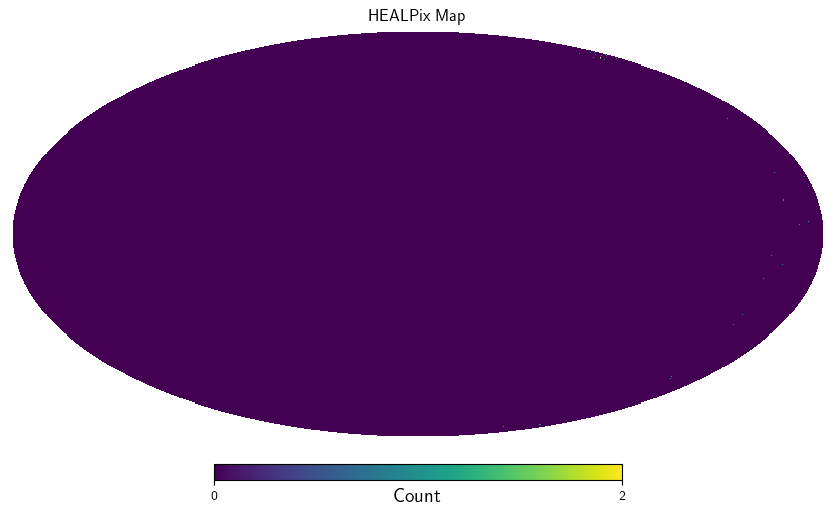

In [101]:
import healpy as hp

nside = 256  # Change this as needed; higher nside = finer resolution
npix = hp.nside2npix(nside)

# Create a blank HEALPix map
healpix_map = np.zeros(npix)


# Convert RA/Dec to pixel indices and fill the map
pixels = hp.ang2pix(nside, np.pi/2 - dec, ra)
np.add.at(healpix_map, pixels, 1)  # Count occurrences

# Optionally, normalize or apply any other mapping as needed

# Save or display the map
hp.mollview(healpix_map, title="HEALPix Map", unit="Count", nest=False)

In [102]:
sigma8 = 0.834
h = 0.674
omegam = 0.3
omegab = 0.05
omegade = 1.0 - omegam
w0 = -1
wa = 0
ns = 0.963
neff = 3.046
mnu = 0
Tcmb0 = 2.725
alpha_B = 0.5
alpha_M = 0.5
log_TAGN = 7.8
ks = 1
keys = ['sigma_8', 'h', 'omega_m', 'omega_b', 'omega_de', 'w0', 'wa',
        'ns', 'neff', 'm_nu', 'Tcmb0', 'alpha_B', 'alpha_M', 'logTAGN', 'ks', 'delta_gamma']
values = [sigma8, h, omegam, omegab, omegade,
          w0, wa,  ns, neff, mnu, Tcmb0, alpha_B, alpha_M, log_TAGN, ks, 0.0]
cosmo = dict(zip(keys, values))
'''frb_cat = ascii.read("./../data/catalogue_updated.csv", data_start=1)
ra = coord.Angle(frb_cat["ra (deg)"], unit=units.degree)
dec = coord.Angle(frb_cat["dec (deg)"], unit=units.degree)
ra = ra.radian - np.pi
dec = dec.radian
counts = len(frb_cat["redshift"])

zet = frb_cat["redshift"][:n_with_host]
z = np.zeros(n_with_host)
DM_obs = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]
    sep = '&'
    DM_obs[i] = frb_cat["dm"][i]
ra = ra[:n_with_host]
dec = dec[:n_with_host]
'''


z = np.zeros(n_with_host)
for i in range(len(zet)):
    z[i] = zet[i]
delta_theta = np.zeros((n_with_host, n_with_host))
for i in range(n_with_host):
    for j in range(n_with_host):
        if (i != j):
            if(np.abs(((DM_obs[i] - DM_obs[j])/DM_obs[i]))<0.01 and i < j):
                print(((DM_obs[i] - DM_obs[j])/DM_obs[i]),i,j)
            delta_theta[i, j] = np.arccos(np.sin(
                ra[i])*np.sin(ra[j]) + np.cos(ra[i])*np.cos(ra[j])*np.cos(dec[i] - dec[j]))






0.0002673082063619685 0 30
0.006923540036122852 1 11
-0.005892789253580072 2 46
0.003911342894393643 7 19
-0.009096077316657104 9 41
-0.002107882096824402 10 35
0.0016932167663015623 10 50
-0.008577753182069792 12 39
-5.5340343110234244e-05 12 42
-0.00796365868434681 15 24
0.0017534844755642033 15 29
0.0028729281767956054 22 43
0.0066298342541436465 22 54
0.00742272100807242 23 24
0.009640370539345038 24 29
-0.0009170572651314217 25 38
-0.0010189525168127166 25 45
-0.008537559117990211 27 59
-0.0006806150743635963 32 40
-0.005419609131220345 33 55
0.008741804558226698 34 46
0.0037931034482759406 35 50
0.00925002267162416 37 47
0.0022218191711253317 37 49
-0.00010180189351524253 38 45
0.008449931412894332 39 42
-0.006572769953051643 41 44
0.003767730496453876 43 54
-0.007093821510297535 47 49
-0.003935532233882965 56 57
-0.0064995672611876405 57 60
0.002993160054719546 67 69


In [103]:

def gaussian_loglike(params):
    sigma_mw = 30.0
    sigma_host = 50.0
    DM_host = params['DM_host']
    A = params['A']
    # mean DM is LSS contribution
    cosmo['alpha_B'] = params['alpha_B']
    cosmo['alpha_M'] = params['alpha_M']
    cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta, flat_sky=True)
    result = 0.0
    DM_mean = A*cov.DM + DM_host/(1.+z) + DM_MW
    cov_mat = A**2*cov.covariance + np.diag((sigma_host/(1.+z)))**2 + np.diag(sigma_mw*np.ones(len(z)))**2 
    precision_mat = np.linalg.inv(cov_mat)
    log_det_cov = np.linalg.slogdet(cov_mat)[1]
    delta = DM_obs - DM_mean
    quadraticform = np.einsum(
        'i,i', delta, np.einsum('ij,j', precision_mat, delta))
    result = -.5*(log_det_cov) - .5*quadraticform  
    return result

def pdf_log_normal(x, mu, sigma):
    return 1./(x*sigma*np.sqrt(np.pi))*np.exp(-(np.log(x) - mu)**2/2/sigma**2)

def LSS_likelihood(DM_LSS, DM_mean, precision_mat, log_det_cov):
    delta = DM_LSS - DM_mean
    quadraticform = np.einsum(
        'i,i', delta, np.einsum('ij,j', precision_mat, delta))
    result = -.5*(log_det_cov) - .5*quadraticform
    return np.exp(result)


def final_likelihood(params):
    sigma_host = 0.6
    DM_host = np.log(50)
    sigma_mw = 30.0
    A = params['A']
    # mean DM is LSS contribution
    cosmo['alpha_B'] = params['alpha_B']
    cosmo['alpha_M'] = params['alpha_M']
    cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta, flat_sky=True)
    DM_mean = A*cov.DM + DM_MW
    cov_mat = A**2*cov.covariance + np.diag(sigma_mw*np.ones(len(z)))**2 
    precision_mat = np.linalg.inv(cov_mat)
    log_det_cov = np.linalg.slogdet(cov_mat)[1]
    N_int = 200
    X_DM_host = np.linspace(1, 1000, N_int)
    integrand = np.zeros_like(X_DM_host)
    for i in range(N_int):
        integrand[i] = LSS_likelihood(
            DM_obs - X_DM_host[i]/(1.0+z), DM_mean, precision_mat, log_det_cov)*pdf_log_normal(X_DM_host[i], DM_host, sigma_host)
    result = np.trapz(integrand, X_DM_host)
    return np.log(result)


def calc_model(params):
    sigma_mw = 30.0
    sigma_host = 50.0
    DM_host = params['DM_host']
    A = params['A']
    # mean DM is LSS contribution
    cosmo['alpha_B'] = params['alpha_B']
    cosmo['alpha_M'] = params['alpha_M']
    cov = frb.covariance_frb_background(cosmo,bias_emu,power_emu,z,delta_theta, flat_sky=True)
    cov_mat = A**2*cov.covariance + np.diag((sigma_host/(1.+z)))**2 + np.diag(sigma_mw*np.ones(len(z)))**2 
    delta = DM_obs - DM_MW - A*cov.DM - DM_host/(1.+z)
    return A*cov.DM + DM_host/(1.+z), np.diag(np.sqrt(cov_mat)), np.dot(delta,np.dot(np.linalg.inv(cov_mat),delta))/len(delta)





In [104]:
alpha_B = np.linspace(0,2.5,10)
alpha_M = np.linspace(0,2.5,10)

loglike_alpha_B = np.zeros_like(alpha_B)
loglike_alpha_M = np.zeros_like(alpha_B)
loglike_alpha_B_ln = np.zeros_like(alpha_B)
loglike_alpha_M_ln = np.zeros_like(alpha_B)

params = {'A':1,'DM_host':50,'alpha_B':0.05, 'alpha_M' : 0.05}

for i in range(len(alpha_B)):
    print(i)
    params['alpha_B'] = alpha_B[i]
    params['alpha_M'] = 0.05
    if alpha_B[i] < 2.5:
        loglike_alpha_B[i] = gaussian_loglike(params)
        loglike_alpha_B_ln[i] = final_likelihood(params)
    else:
        loglike_alpha_B[i] = -1e200
        loglike_alpha_B_ln[i] = -1e200
    
    params['alpha_M'] = alpha_M[i]
    params['alpha_B'] = 0.05
    loglike_alpha_M[i] = gaussian_loglike(params)
    loglike_alpha_M_ln[i] = final_likelihood(params)


0
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_29236/1238060553.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  result = np.trapz(integrand, X_DM_host)


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:20<00:00,  3.54it/s]


1
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:20<00:00,  3.52it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.71it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.68it/s]


2
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.68it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.58it/s]


3
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.55it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:20<00:00,  3.51it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


4
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.60it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


5
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.64it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


6
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


7
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


8
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.67it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.66it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.62it/s]


9
Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.65it/s]


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


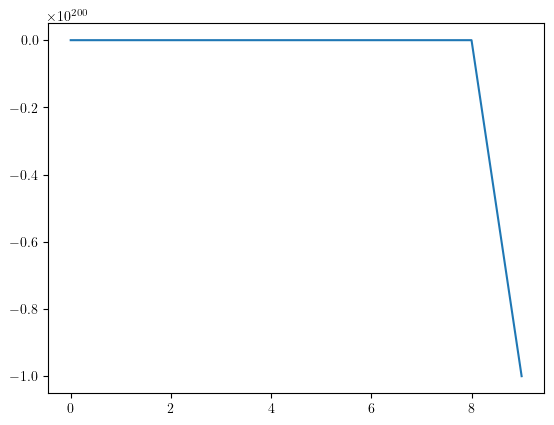

In [111]:
plt.plot(loglike_alpha_B - np.max(loglike_alpha_B))

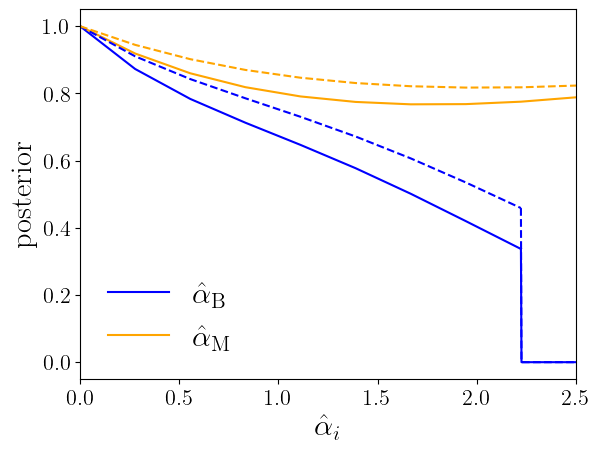

In [120]:
import os 
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
fig, ax = plt.subplots()

fontsi = 16
fontsi2 = 22

plt.tick_params(labelsize=fontsi)


plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('image', interpolation='none')
fac = 1
plt.plot(alpha_B[:-1], np.exp(fac*(loglike_alpha_B - np.max(loglike_alpha_B)))[:-1], label = r"$\hat{\alpha}_\mathrm{B}$", color = "blue")
plt.plot(alpha_M, np.exp(fac*(loglike_alpha_M - np.max(loglike_alpha_M))), label = r"$\hat{\alpha}_\mathrm{M}$", color = "orange")


alpha_B_aux = np.linspace(alpha_B[-2],alpha_B[-1],100)
like_B_aux = np.zeros_like(alpha_B_aux)
like_B_aux[0] = np.exp(fac*(loglike_alpha_B - np.max(loglike_alpha_B)))[-2]

plt.plot(alpha_B_aux, like_B_aux, color = "blue")

like_B_aux[0] = np.exp(fac*(loglike_alpha_B_ln - np.max(loglike_alpha_B_ln)))[-2]

plt.plot(alpha_B_aux, like_B_aux, color = "blue", ls = "--")


plt.plot(alpha_B[:-1], np.exp(fac*(loglike_alpha_B_ln - np.max(loglike_alpha_B_ln)))[:-1], color = "blue", ls = "--")
plt.plot(alpha_M, np.exp(fac*(loglike_alpha_M_ln - np.max(loglike_alpha_M_ln))), color = "orange", ls = "--")

plt.xlabel(r"$\hat{\alpha}_i$", fontsize = fontsi2)
plt.ylabel(r"$\mathrm{posterior}$", fontsize = fontsi2)

plt.legend(fontsize = fontsi2, frameon = False)
plt.xlim(0,2.5)
#plt.tight_layout()
plt.savefig("fit_host_frb.pdf")


In [107]:
params = {'A':1.1,'DM_host':90,'alpha_B':0.05, 'alpha_M' : 0.05}

model, error, chi2 = calc_model(params)


Calculating FRB-Covariance


100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_29236/2595851804.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mathrm{DM} [\mathrm{pc}\;\mathrm{cm}^{-3}]$", fontsize = fontsi2)


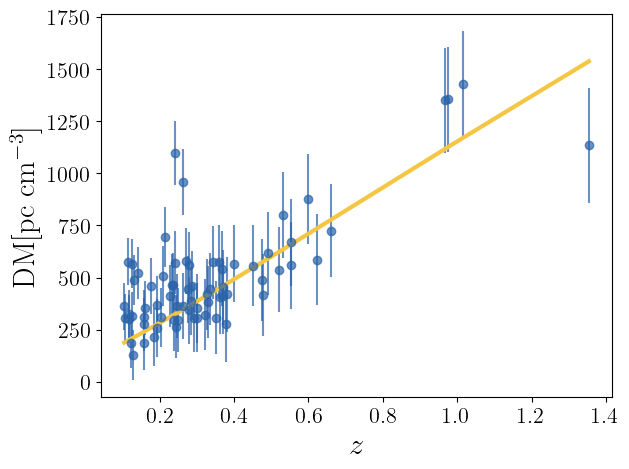

In [108]:
fig, ax = plt.subplots()

fontsi = 16
fontsi2 = 22

plt.tick_params(labelsize=fontsi)


plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('image', interpolation='none')


idx = np.where((DM_obs - DM_MW > 0) & (DM_obs < 1000))[0]
plt.errorbar(z, DM_obs - DM_MW , error, ls ="", marker = "o", color = "#2A63AA", alpha = .7)

#plt.errorbar(z[idx], DM_obs[idx] - DM_MW[idx] , error[idx], ls ="", marker = "o")
plt.plot(np.sort(z), np.sort(model), lw = 3, color="#F4C643")
plt.xlabel("$z$", fontsize = fontsi2)
plt.ylabel("$\mathrm{DM} [\mathrm{pc}\;\mathrm{cm}^{-3}]$", fontsize = fontsi2)
plt.tight_layout()
plt.savefig("model.pdf")


In [109]:
frb_name_new = []
for i in take_index:
    numbers = "".join([char for char in frb_name[i] if char.isdigit()])
    frb_name_new.append((frb_name[i]))
    
for i in range(n_with_host):
    print(frb_name_new[i], DM_obs[i])





FRB20230708A 411.51
FRB20191106C 332.2
FRB20220914A 631.28
FRB20190608 339.5
FRB20190110C 221.6
FRB20240310A 601.8
FRB20240213A 357.4
FRB20230628A 345.15
FRB20210807D 251.3
FRB20240114A 527.7
FRB20210410D 578.78
FRB20231226A 329.9
FRB20230526A 361.4
FRB20220920A 314.99
FRB20200430 380.25
FRB20210603A 500.147
FRB20220529A 246.0
FRB20220725A 290.4
FRB20121102 557.0
FRB20221106A 343.8
FRB20240215A 549.5
FRB20210117A 728.95
FRB20221027A 452.5
FRB20191001 507.9
FRB20190714 504.13
FRB20221101B 490.7
FRB20190520B 1210.3
FRB20220825A 651.24
FRB20191228 297.5
FRB20220307B 499.27
FRB20221113A 411.4
FRB20220831A 1146.25
FRB20231123B 396.7
FRB20230307A 608.9
FRB20221116A 640.6
FRB20220105A 580.0
FRB20210320C 384.8
FRB20221012A 441.08
FRB20240229A 491.15
FRB20190102 364.5
FRB20220506D 396.97
FRB20230501A 532.5
FRB20180924 361.42
FRB20230626A 451.2
FRB20180301 536.0
FRB20231220A 491.2
FRB20211203C 635.0
FRB20220208A 437.0
FRB20220726A 686.55
FRB20230902A 440.1
FRB20200906 577.8
FRB20240119A 483.1
FR

In [110]:
from scipy.stats import norm
from nautilus import Prior
from nautilus import Sampler

prior = Prior()
prior.add_parameter('alpha_B', dist=(0, 2.5))
prior.add_parameter('alpha_M', dist=(0, 3))
prior.add_parameter('A', dist=(0.5,10))
prior.add_parameter('DM_host', dist=(10,500))


sampler = Sampler(prior, gaussian_loglike, n_live=100, filepath='sampling_100.hdf5')
sampler.run(verbose=True)


ModuleNotFoundError: No module named 'nautilus'

(array([0.010938  , 0.01169948, 0.01663593, 0.01990546, 0.02123789,
        0.02264037, 0.02431976, 0.02990346, 0.0301291 , 0.03719258,
        0.04341719, 0.04340533, 0.04570413, 0.04882607, 0.05692185,
        0.0579252 , 0.06239415, 0.06271223, 0.05552515, 0.05363873,
        0.04970588, 0.04075964, 0.03986504, 0.03283083, 0.02849487,
        0.02253242, 0.01207352, 0.0093144 , 0.0062106 , 0.00314073]),
 array([7.45277991e-04, 8.40398113e-02, 1.67334345e-01, 2.50628878e-01,
        3.33923411e-01, 4.17217944e-01, 5.00512478e-01, 5.83807011e-01,
        6.67101544e-01, 7.50396077e-01, 8.33690611e-01, 9.16985144e-01,
        1.00027968e+00, 1.08357421e+00, 1.16686874e+00, 1.25016328e+00,
        1.33345781e+00, 1.41675234e+00, 1.50004688e+00, 1.58334141e+00,
        1.66663594e+00, 1.74993048e+00, 1.83322501e+00, 1.91651954e+00,
        1.99981408e+00, 2.08310861e+00, 2.16640314e+00, 2.24969768e+00,
        2.33299221e+00, 2.41628674e+00, 2.49958128e+00]),
 <BarContainer object of 30 

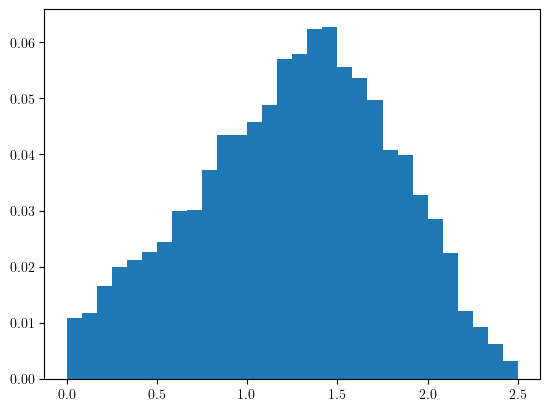

In [ ]:
points, log_w, log_l = sampler.posterior()
plt.hist(points[:,0], bins = 30, weights=np.exp(log_w))

In [ ]:
s = np.random.normal(100, 50, 10000)